<h1><center>Handwritten Digits Generation by Generative Adversarial Nets (GANs)</center></h1>

<h4><center> Wenjin Tao </center></h4>

## 1. Introduction

This project is to learn to implement a generative adversatial network trained on the MNIST dataset to generate handwritten digits as in it.

**GANs** was first published by *Ian J. Goodfellow, et al.* in 2014 ([Paper](https://arxiv.org/pdf/1406.2661.pdf)). As its endless possibilities, more and more GANs have been developed since then. More GANs can be found from this github [repository](https://github.com/wiseodd/generative-models).

> The basic idea behind GANs is that we simultaneously train two models: a generative model $G$ that caputres the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$. The training procedure for $G$ is to maximize the probability of $D$ making a mistake.

More intuitively, in GANs we have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator trys to make fake data to pass to the discriminator. The dicriminator accepts real/fake data and predicts whether the data it's received is real or not. The generator is trained to fool the dicriminator, it wants to output data that looks as close as possible as real data. And the discriminator is trained to classify if the data is real or fake. Finally the generator learns to make data that is indistinguishable from real data to the discriminator.


## 2. Approach Outline

![GAN diagram](assets/gan_diagram.png)

The general structure of a GAN is shown in the diagram above, in this project we are using MNIST images as the training data. The latent sample is a random vector the generator uses to contruct the fake image. As the generator learns through training, it figures out how to map these random vectors to recognizable digits that can fool the discriminator.

The output of the discriminator is a sigmoid function, where 0 indicates a fake image and 1 indicates an real image.

Now we're interested in generating new images, so we can throw out the discriminator after training. 

![GAN Network](assets/gan_network_mnist.png)

The above figure shows the network implemented in this project. Each of the generator and discriminator only has one hidden layer.

## 3. Implementation

### 3.1 Preparation

In [1]:
# Import needed packages
import pickle as pkl
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Let's check the python and tensorflow versions
import sys
print('Requirements: Python>3.5, TF=1.0.1')
print('Python:\n    ', sys.version)
print('TensorFlow:\n    ', tf.__version__)

Requirements: Python>3.5, TF=1.0.1
Python:
     3.5.3 |Continuum Analytics, Inc.| (default, Feb 22 2017, 21:28:42) [MSC v.1900 64 bit (AMD64)]
TensorFlow:
     1.0.1


In [3]:
# Read in the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


### 3.2 Model Inputs

First we need to create the inputs for our graph when using TensorFlow. We need two inputs, one for the discriminator and another one for the generator. Here we'll call the discriminator input `inputs_real` and the generator input `inputs_z`. We'll assign them the appropriate sizes for each of the networks.

The `model_inputs` function is implemented below, which creates the placeholders for `inputs_real` and `inputs_z` using the input sizes `real_dim` and `z_dim` respectively.

In [4]:
def model_inputs(real_dim, z_dim):
    ''' Create the inputs
    
        Arguments
        ---------
        real_dim: discriminator input size
        z_dim: generator input size
        
        Returns
        -------
        inputs_real, inputs_z: placeholders of inputs 
    '''
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

### 3.3 Generator Network

Let's build the generator network. 

#### Leaky ReLU

We only use one hidden layer. We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values. TensorFlow doesn't provide an operation for leaky ReLUs, so we'll need to make one. For this we can take the outputs from a linear fully connected layer and pass them to `tf.maximum`. Typically, a parameter `alpha` sets the magnitude of the output for negative values. So, the output for negative input (`x`) values is `alpha*x`, and the output for positive `x` is `x`:
$$
f(x) = max(\alpha * x, x)
$$

#### Tanh Output
The generator has been found to perform the best with $tanh$ for the generator output. This means that we'll have to rescale the MNIST images to be between -1 and 1, instead of 0 and 1.

#### Variable Scope
Here we need to use `tf.variable_scope` for two reasons. 

- Firstly, we're going to make sure all the variable names start with `'generator'`. Similarly, we'll prepend `'discriminator'` to the discriminator variables. This will help out later when we're training the separate networks.

- We could just use `tf.name_scope` to set the names, but we also want to reuse these networks with different inputs. For the generator, we're going to train it, but also _sample from it_ as we're training and after training. The discriminator will need to share variables between the fake and real input images. So, we can use the `reuse` keyword for `tf.variable_scope` to tell TensorFlow to reuse the variables instead of creating new ones if we build the graph again.

In [5]:
def generator(z, out_dim, n_units=128, reuse=False,  alpha=0.01):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # A fully connected hidden layer, set the activation to None
        h1 = tf.layers.dense(z, n_units, activation=None)
        # Activation fn: Leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)
        
        # Logits
        logits = tf.layers.dense(h1, out_dim, activation=None)
        # tanh output
        out = tf.tanh(logits)
        
        return out

### 3.4 Discriminator Network

Let's build the discriminator network.

The discriminator network is almost exactly the same as the generator network, except that we're using a sigmoid output layer.


In [6]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(x, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha*h1, h1)
        
        logits = tf.layers.dense(h1, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

### 3.5 Hyperparameters

Some hyperparameters are seted as follows.

In [7]:
# Size of input image to discriminator
input_size = 784 # 28x28 MNIST images, flattened
# Lenth of latent vector to generator
z_size = 100
# Sizes of hidden layers in generator and discriminator
g_hidden_size = 128
d_hidden_size = 128
# Leak factor for leaky ReLU
alpha = 0.01
# Label smoothing 
smooth = 0.1

### 3.6 Build Graph

Let's build the graph from the above functions.

First is to get our inputs, `input_real, input_z` from `model_inputs()` using the sizes of the **input** and **z**.

Then, we'll create the generator, `generator(input_z, input_size)`. This builds the generator with the appropriate input and output sizes (which should be equal to the input size of the discriminator).

Then for the discriminators, we'll build two of them, one for real data and one for fake data. Since we want the weights to be the same for both real and fake data, we need to reuse the variables. For the fake data, we're getting it from the generator as `g_model`. So the real data discriminator is `discriminator(input_real)` while the fake discriminator is `discriminator(g_model, reuse=True)`.

In [8]:
# Create a new graph
tf.reset_default_graph()
# Create our input placeholders
input_real, input_z = model_inputs(input_size, z_size)

# Generator network here, (input_size: size of the generator output)
g_model= generator(input_z, input_size, n_units=g_hidden_size)
# g_model is the generator output

# Disriminator network here
d_model_real, d_logits_real = discriminator(input_real, n_units=d_hidden_size)
d_model_fake, d_logits_fake = discriminator(g_model, n_units=d_hidden_size, reuse=True)

### 3.7 Discriminator and Generator Losses

Let's calculate the losses.
- For the discriminator, the total loss is the sum of the losses for real and fake images. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits( )`. We'll also wrap that in `tf.reduce_mean( )` to get the mean for all the images in the batch. 

- For the real image logits, we'll use `d_logits_real` which we got from the discriminator in the cell above. For the labels, we want them to be all ones, since these are all real images. To help the discriminator generalize better, the labels are reduced a bit from 1.0 to 0.9, for example,  using the parameter `smooth`. This is known as **label smoothing**, typically used with classifiers to improve performance.

- The discriminator loss for the fake data is similar. The logits are `d_logits_fake`, which we got from passing the generator output to the discriminator. These fake logits are used with labels of all zeros. Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

- Finally, the generator losses are using `d_logits_fake`, the fake image logits. But, now the labels are all ones. The generator is trying to fool the discriminator, so it wants to discriminator to output ones for fake images.

In [26]:
# Calculate losses
# Discriminator loss for real images
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)*(1-smooth)))
# Discriminator loss for fake images
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_real)))
# Sum the above two losses
d_loss = d_loss_real + d_loss_fake

# Generator loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.ones_like(d_logits_fake)))

### 3.8 Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph. In the variables, we can use `var.name.startswith('generator/discriminator')` to choose the variables of the generator/discriminator.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize()` method. This tells the optimizer to only update the listed variables.

In [10]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

# Use AdamOptimizer().minimize() as the optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) 
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) 

### 3.9 Training

In [11]:
# Set the training epochs and batch_size
epochs = 200
batch_size = 100

# Store samples and losses in lists
samples = []
losses = []
# Instantiate a saver, and only save generator variables
saver = tf.train.Saver(var_list=g_vars)

# Launch the graph in a session
with tf.Session() as sess:
    # First, initialize all the variables
    sess.run(tf.global_variables_initializer())
    for e in range(epochs): # Go through all the epochs
        for ii in range(mnist.train.num_examples//batch_size): # Go through all the batches
            batch = mnist.train.next_batch(batch_size)
            
            # Get images, reshape and rescale (-1 to +1) to pass to D
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers over each batch
            _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(input_z, input_size, reuse=True),
                       feed_dict={input_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch 1/200... Discriminator Loss: 0.4237... Generator Loss: 3.0754
Epoch 2/200... Discriminator Loss: 0.4175... Generator Loss: 4.0404
Epoch 3/200... Discriminator Loss: 0.6086... Generator Loss: 2.4067
Epoch 4/200... Discriminator Loss: 1.6639... Generator Loss: 4.6752
Epoch 5/200... Discriminator Loss: 1.9381... Generator Loss: 1.7688
Epoch 6/200... Discriminator Loss: 0.7373... Generator Loss: 2.6908
Epoch 7/200... Discriminator Loss: 1.5508... Generator Loss: 3.6040
Epoch 8/200... Discriminator Loss: 1.8048... Generator Loss: 1.6595
Epoch 9/200... Discriminator Loss: 0.9544... Generator Loss: 2.2930
Epoch 10/200... Discriminator Loss: 0.7888... Generator Loss: 2.4913
Epoch 11/200... Discriminator Loss: 1.1426... Generator Loss: 1.0288
Epoch 12/200... Discriminator Loss: 1.0149... Generator Loss: 1.8733
Epoch 13/200... Discriminator Loss: 1.4822... Generator Loss: 1.3535
Epoch 14/200... Discriminator Loss: 2.2121... Generator Loss: 1.4162
Epoch 15/200... Discriminator Loss: 1.1040.

## 4. Results

### 4.1. Training Loss

First, let's check out the training losses of the generator and discriminator. They are stored in the list `losses`

(200, 2)


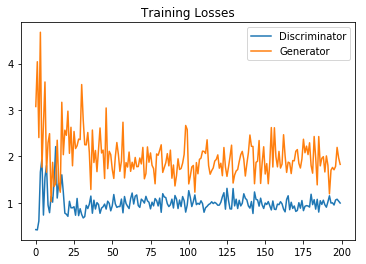

In [19]:
# Create a subplot figure
fig, ax = plt.subplots()
# Convert list to numpy array
losses = np.array(losses)
# Let's check the loss data first
print(losses.shape)
# Plot the discriminator loss and generator loss
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
# Add the title and turn on the legend
plt.title("Training Losses")
plt.legend()

From the above figure, we can see that the losses are getting lower and lower as the training's proceding. Because of the time consumption, I limited the `epochs` to 200.

### 4.2. Review of Generator Samples during Training

After training, we can visualize samples of images from the generator. First let's check out images taken while training.

In [20]:
# Fn to visualize sample given the epoch
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        #print(img.shape)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

In [21]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    # Let's check out the data
    print('Training epochs: ', len(samples))
    print('Sample shape: ', samples[0].shape)

Training epochs:  200
Sample shape:  (16, 784)


First, let's view the digits samples from the first training epoch. We can see that they are quite noisy only with the center region highlighted.

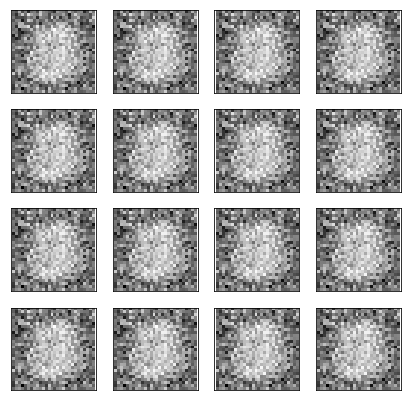

In [22]:
# Samples from the first epoch
_ = view_samples(0, samples)

Digits shown below are samples from the last training epoch. We can see that the generator is able to reproduce some digits. But the images are still noisy. 

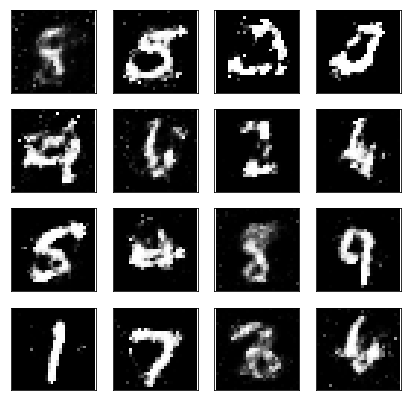

In [23]:
# Samples from the last epoch
_ = view_samples(-1, samples)

To view the samples' changing during training, let's sample out some data (10 epochs) for visualization.

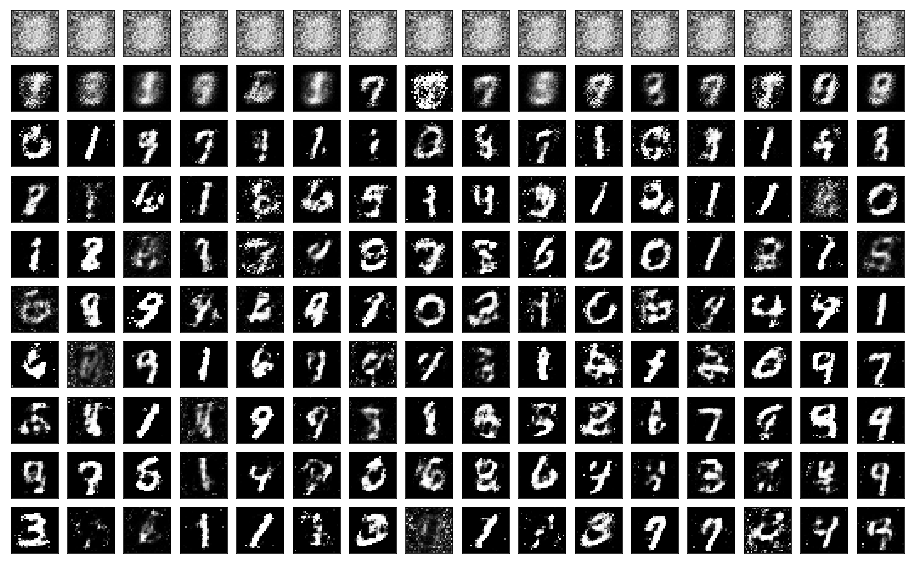

In [24]:
# Set the rows & cols for the digits
rows, cols = 10, 16
fig, axes = plt.subplots(figsize=(16, 10), nrows=rows, ncols=cols, sharex=True, sharey=True)
#print(len(axes))
# Sample out #epochs=#rows
for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    # For each sampled epoch, sample out #imgs=#cols
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

In the above figure, each row shows the generated samples from the generator at a epoch, and we sampled out 10 epochs out of 200 for visulization. That's why the figure has 10 rows in total.

We can see that at the very beginning, they are all noise. But as the training's proceding, the noisy white spots clusters in the central region. After which, we can start to see some digit-like structures appear out of the noise. Which means the generator is gradully learning to generate digits to fool the discriminator.

### 4.3. Generated Digits Uing the Trained Generator

To generate new handwritten digits, we need to feed in a new latent vector $z$ into the trained generator.

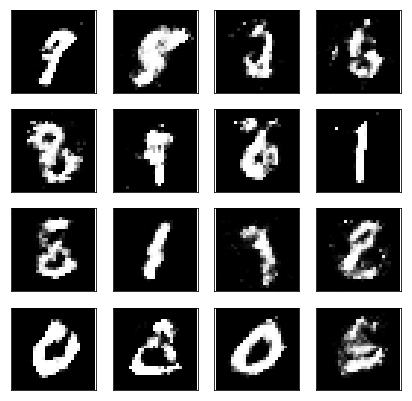

In [25]:
# Save the trained variables of the generator, 
# use var_list to specify the variables
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    # Restore the tf.train session as 'sess'
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Create a new latent vector z (z_size)
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    # Feed the new latent vetor z to the generator
    gen_samples = sess.run(
                   generator(input_z, input_size, reuse=True),
                   feed_dict={input_z: sample_z})
    
# Let's visualize the generated image
_ = view_samples(0, [gen_samples])

### 4.4. Next

In this project only one hidden layer was used in the generator/discriminator. As shown in the above image, the generated images still have a lot of noise and doesn't really look like handwritten digits. Next, using more hidden layers could improve the performance and implementing [Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf) on inputs of each layer could improve the training robustness.